# Sarkas DYI

In this notebook you will be completing some tasks in order to learn how to use Sarkas. The learning goals of this notebook are

- Write your own input file.
- Do some convergence studies.

## Task No. 1

**&#9989; Do this:** Write an input file for a simulation of a Yukawa one component plasmas (YOCP). The plasma is made of Al ions witha a ionization charge of 3.0. The system is at $T = 1$ eV and has a mass density $\rho = 2.7213$ g/cc with the electrons at the same temperature, $T_e = 1$ eV. The particles interact via the Yukawa potential and the screening parameter $\kappa = a_{\rm ws}/\lambda_{\rm TF}$ is calculated using the Thomas-Fermi model. 

The algorithm for the force is a simple particle-particle with linked cell list; no need for PPPM here. Choose the cut-off to be `rc = 6.4e-08` cm. 

Use a verlet integrator with a timestep `dt` such that $dt/\tau_{\omega_p} = 0.005052$ where $\tau_{\omega_p} = 2\pi/\omega_p$ is the plasma period. The system is equilibrated using a Berendsen thermostat with `berendsen_tau = 218`. The thermostat should turn on after 400 steps. The particles positions should be initialized at random without any rejection radius. Equilibrate the system for 4 000 steps and then collect data for 4 000 steps. Save data every 20 steps during equilibration and every 2 steps in the production phase. Use periodic boundary conditions. 

In order to find `rc` and `dt` is to have an input file with some initial values and then do some preprocessing. Follow the instructions below

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import os

plt.style.use('MSUstyle')

# Import sarkas
from sarkas.processes import PreProcess, Simulation, PostProcess
from sarkas.tools.observables import RadialDistributionFunction, Thermodynamics, VelocityAutoCorrelationFunction

In [2]:
# Create the file path to the YAML input file
input_file_name = os.path.join('input_files', 'yocp_convergence.yaml')
pre = PreProcess(input_file_name)
pre.setup(read_yaml=True)
pre.run()

**&#9989; Do this:** Using the information printed to screen calculate the `rc` and `dt`. If you want to use Sarkas, here are a few hints:

- Recall that `pre.species` is a list whose elements are instances of `sarkas.plasma.Species`. Try running the line `pre.species[0]` what do you see and how would you access the attributes?
- The plasma frequency can be accessed via `pre.species[0].plasma_frequency` or `pre.paramters.total_plasma_frequency`.
- The screening length can be accessed `pre.potential.screening_length`.
- The Wigner-Seitz radius $a_ws$ via `pre.potential.a_ws` or `pre.parameters.a_ws`
- The constant $4\pi \epsilon_0$ can be accessed via `pre.potential.fourpie0` or `pre.parameters.fourpie0`.

In [3]:
display(pre.potential.a_ws, pre.potential.screening_length, pre.potential.fourpie0)

1.5797739343056807e-08

4.885583616754373e-09

1.0

In [4]:
# Display the information of the first species
pre.species[0]

Species( 
	ai : 1.5797739343056807e-08
	ai_dens : 1.5797739343056807e-08
	atomic_weight : 26.981999940474548
	c0 : 29979245800.0
	charge : 1.440961413771079e-09
	concentration : 1.0
	coupling : 82.03503453140941
	cyclotron_frequency : None
	debye_length : 1.0070119722652659e-09
	dimensions : 3
	eV2J : 1.602176634e-19
	eV2K : 11604.51812
	fourpie0 : 1.0
	hbar : 1.054571817e-27
	initial_spatial_distribution : random_no_reject
	initial_velocity : [0. 0. 0.]
	initial_velocity_distribution : boltzmann
	kB : 1.380649e-16
	landau_length : 1.6285615355064204e-05
	mass : 4.513068464544e-23
	mass_density : 2.713
	name : Al
	num : 250
	number_density : 6.055173047929617e+22
	plasma_frequency : 187104659092106.0
	QFactor : 5.190924489942867e-16
	temperature : 11604.51812
	temperature_eV : 1.0
	units_dict : {'temperature': '[K]', 'Hertz': '[1/s]', 'frequency': '[rad/s]', 'time': '[s]', 'electron volt': '[eV]', 'number density': '[N/cc]', 'mass': '[g]', 'mass density': '[g/cc]', 'charge': '[esu]', '

In [5]:
# Calculate the plasma period using the plasma frequency attribute
tau_wp = 2.0 * np.pi / pre.species[0].plasma_frequency
# Calculate the desired dt
dt = 0.00502 * tau_wp
print(f"dt: {dt:.4e}")

dt: 1.6858e-16


**&#9989; Do this:** Once you have defined all your parameters run simulations for `N = [250, 500, 1000, 2000, 5000]`. This can be achieved by creating new input files with the only difference being the number of particles in species and a different `job_dir`. If you don't change `job_dir` you will overwrite each simulation. If you don't want to clutter your screen you can set `verbose: False` in the `IO` section of the input file. Also having a script for running simulations might help.


In [6]:
num_particles = np.array([250, 500, 1000, 2000, 5000])


In [7]:

# for i, N in enumerate(num_particles):
#     args = {'Particles': [
#         {"Species" :{
#             'name' :'Al',
#             'number_density': 6.03e+22,
#             'mass': 4.513068464544e-23,
#             'Z': 3.0,
#             'temperature_eV': 1.0,
#             'num': N,
#             'replace': True
#             }
#         }
#     ],
#     "IO" : {
#              'verbose': False,
#             'job_dir': f'N{N}'
#                 }
#     }
#     # Initialize the Simulation class
#     sim = Simulation(input_file_name)
    
#     # Setup the simulation's parameters
#     sim.setup(read_yaml=True, other_inputs=args)
#     # Run the simulation
#     sim.run()
#     print(f"N = {N} done")

**&#9989; Do this:** Once the simulations are done, it is time to analyze the data. Following the tutorial and quickstarts guides, for each simulation, instantiate a `PostProcess` and run its setup method. Then using the `Thermodynamics` class make plots of the temperature and energy using the method `temp_energy_plot()` (don't forget to pass the `PostProcess` instance).

In [8]:
def make_temp_energy_plot(input_file_name, args):
    
    # Initialize the Postprocessing class
    postproc = PostProcess(input_file_name)
    # Read the simulation's parameters and assign attributes
    postproc.setup(read_yaml=True, other_inputs=args)

    therm = Thermodynamics()
    therm.setup(postproc.parameters)
    therm.compute()
    therm.temp_energy_plot(postproc)
    

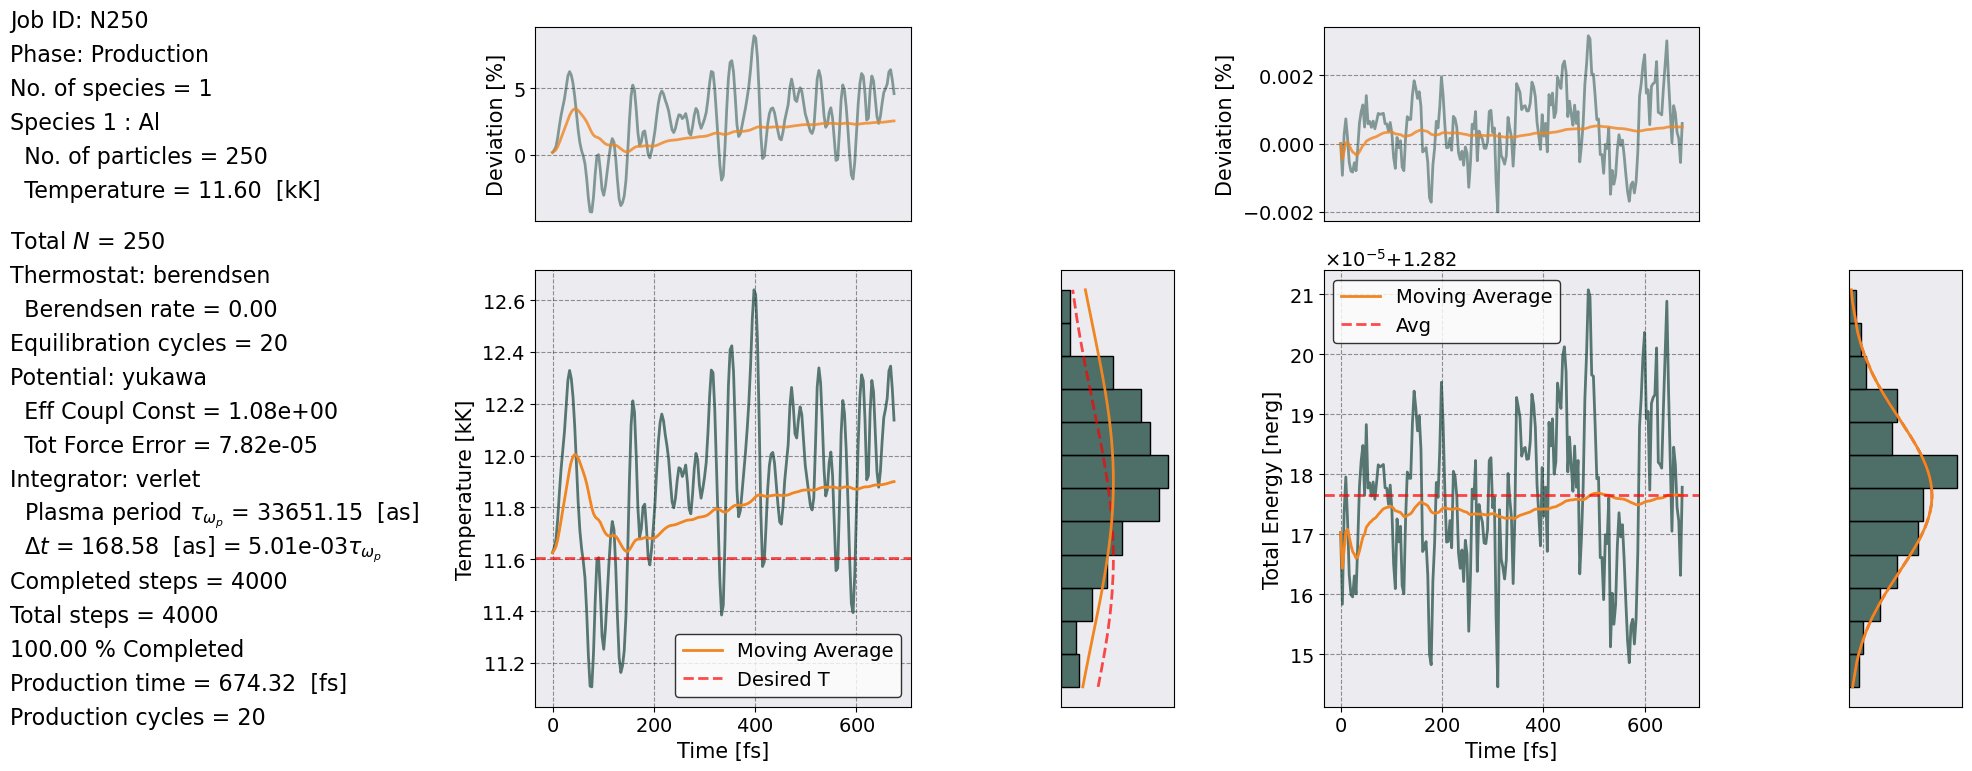

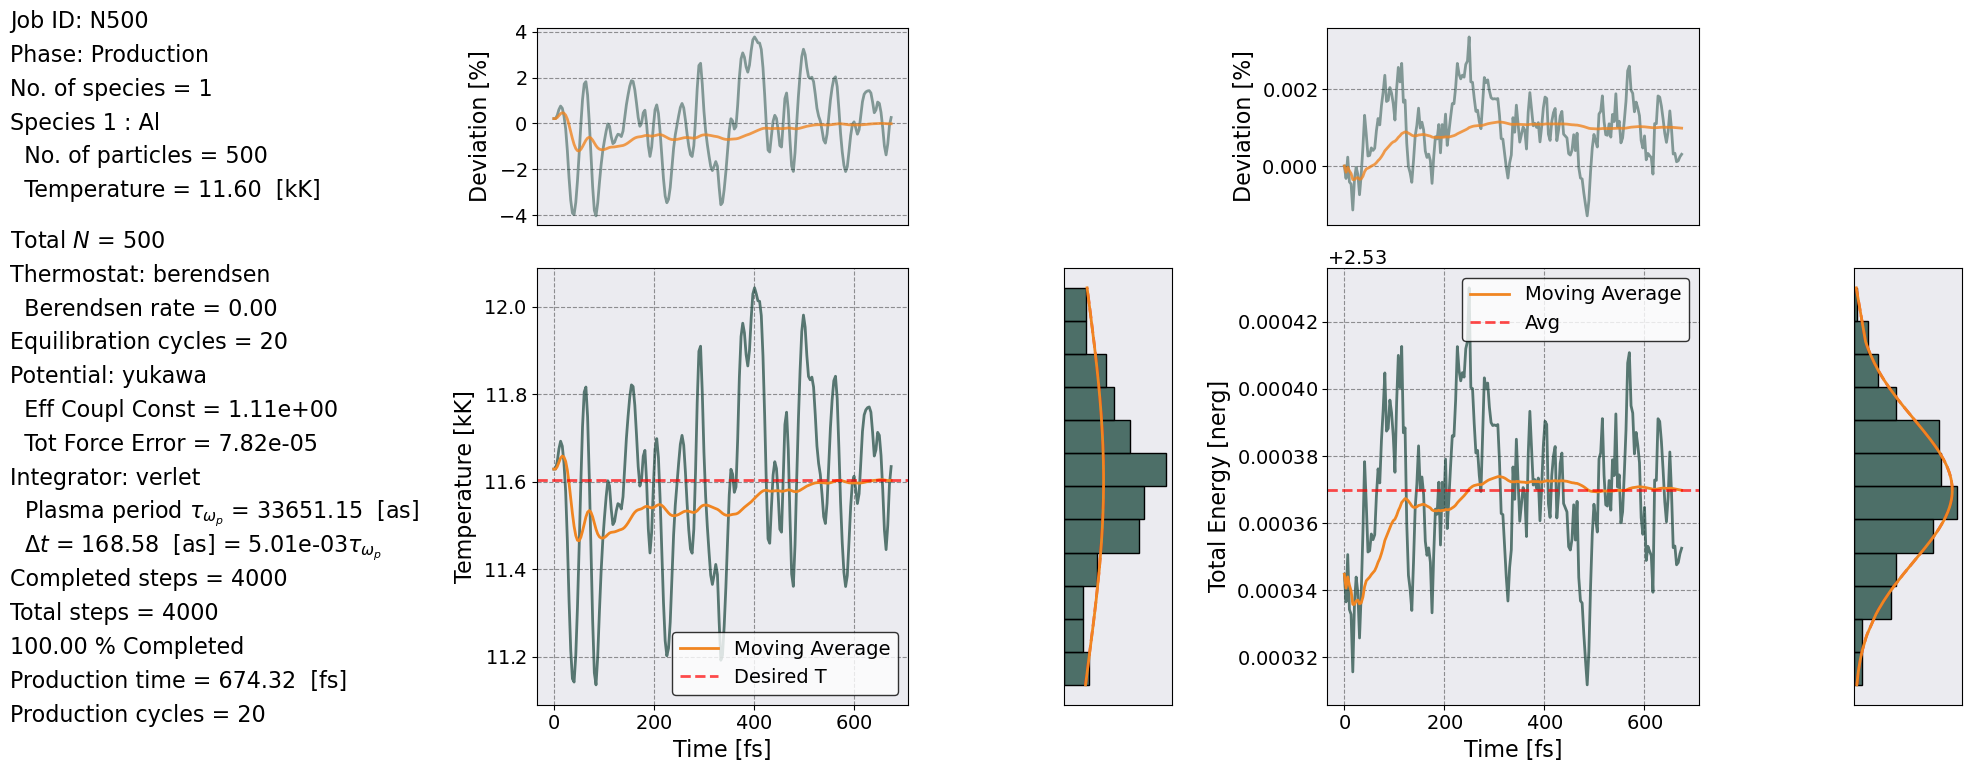

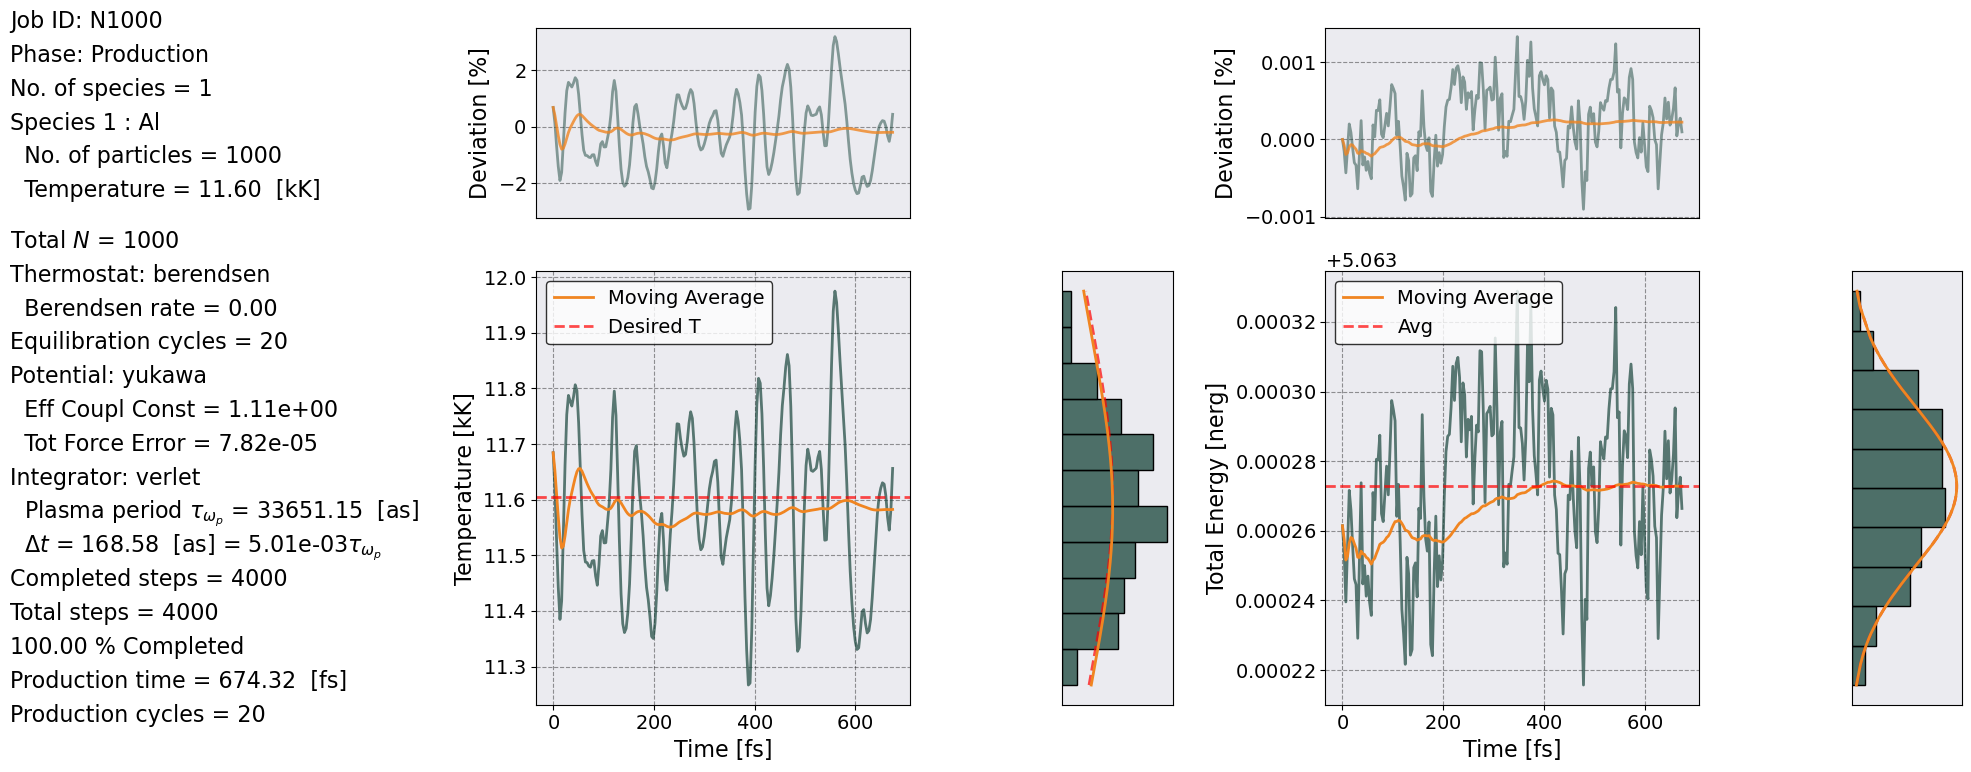

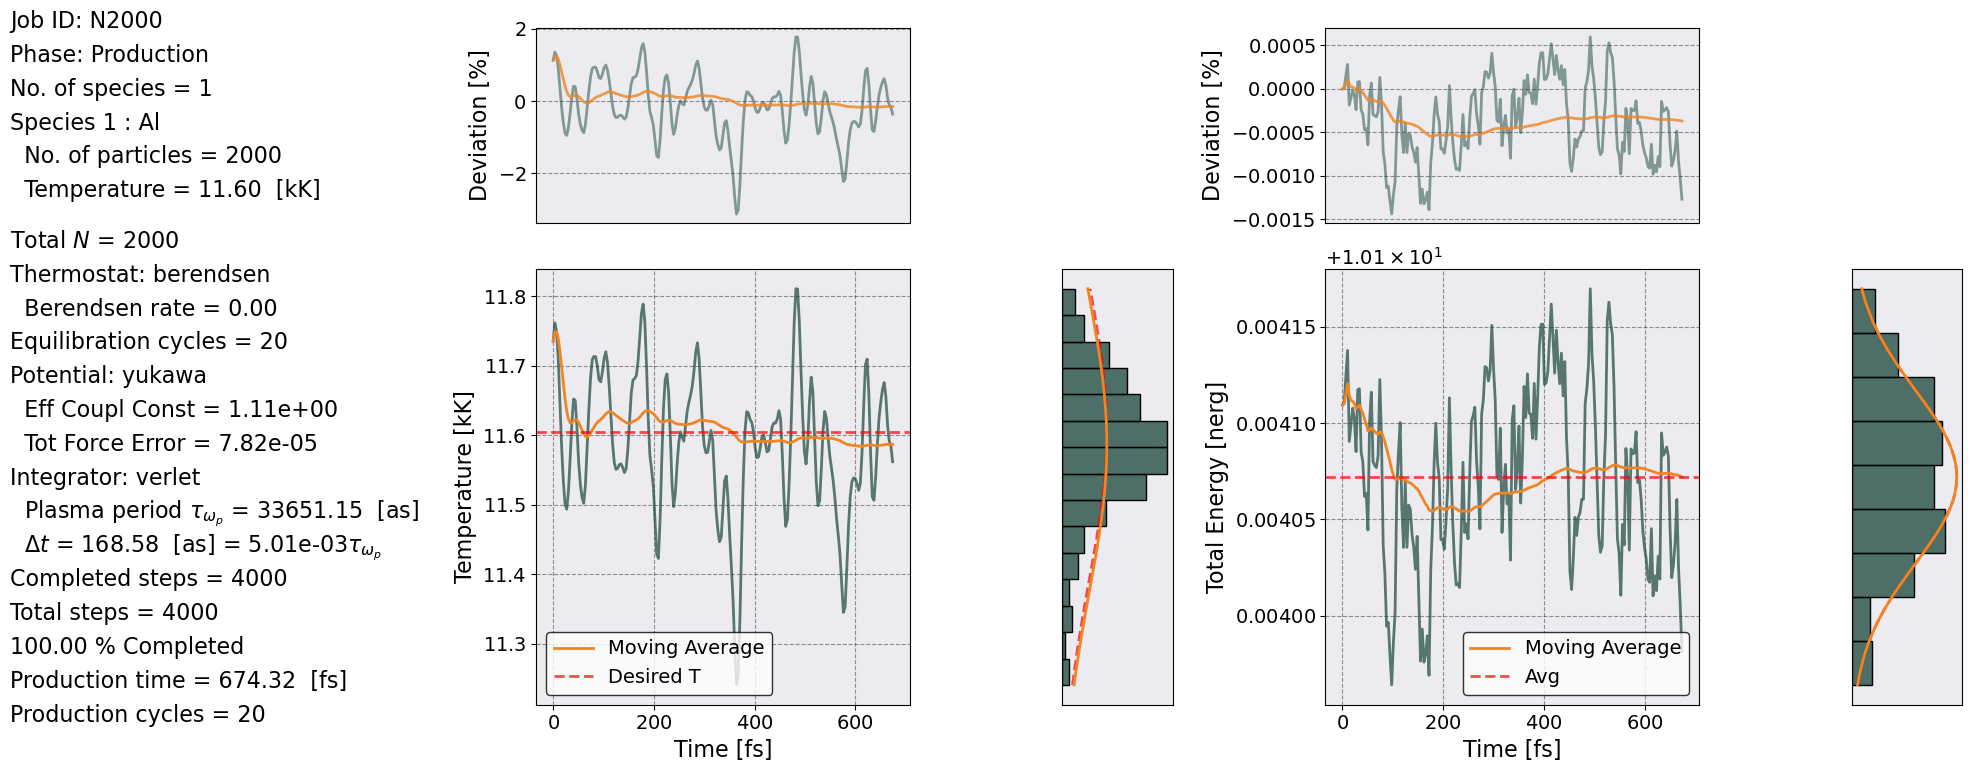

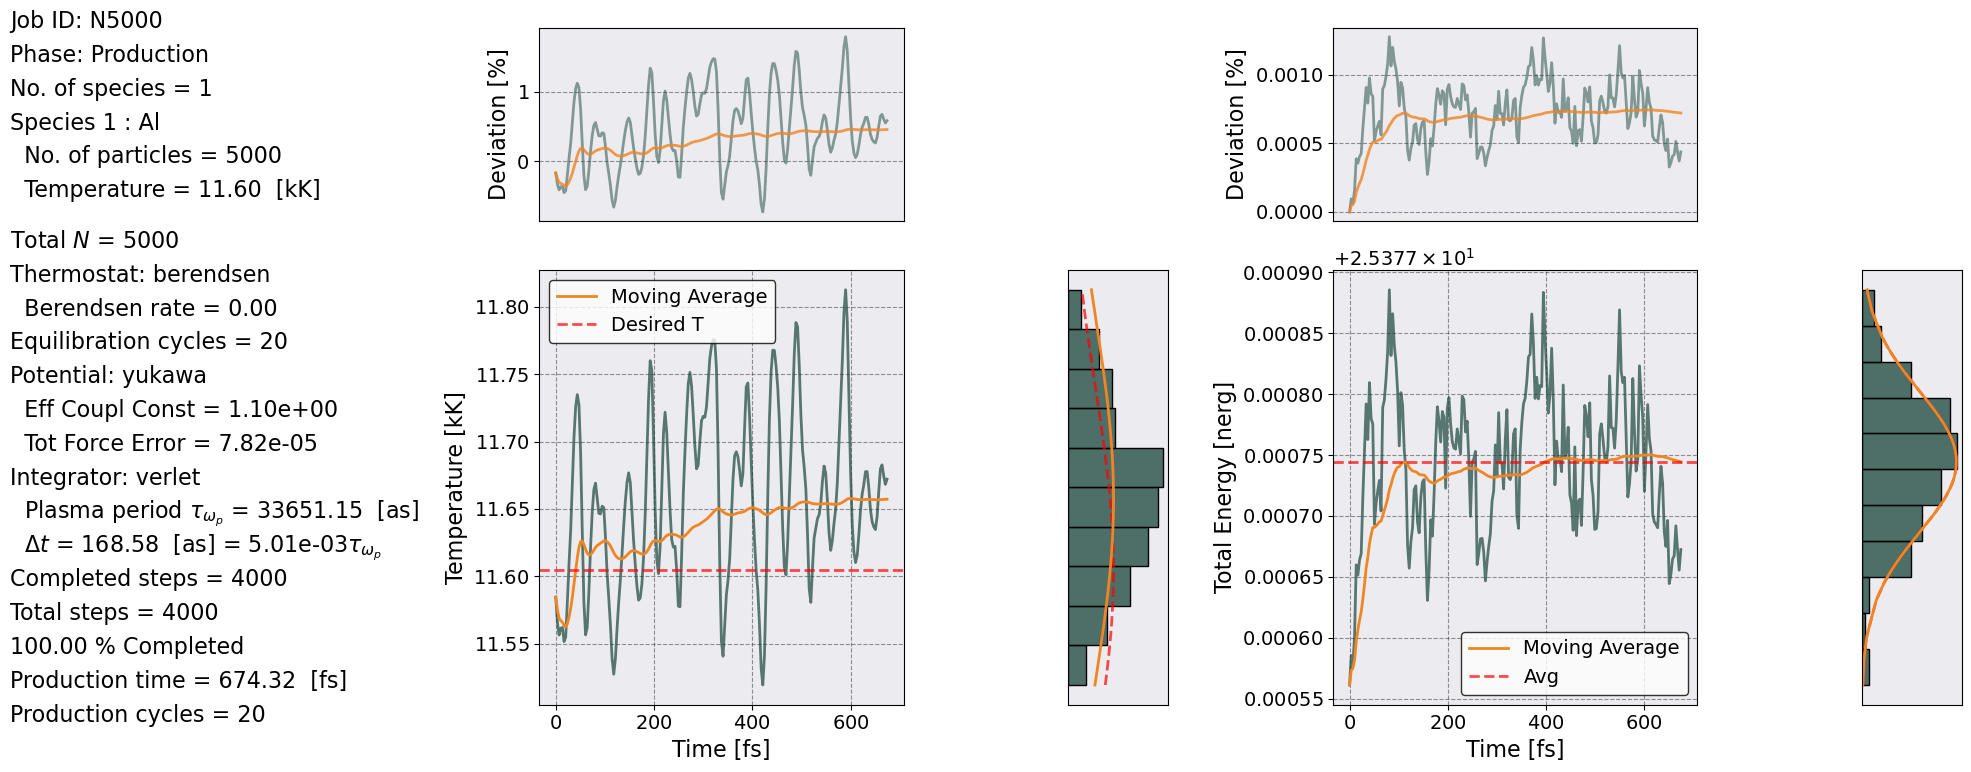

In [9]:
for i, N in enumerate(num_particles):
    args = {'Particles': [
        {"Species" :{
            'name' :'Al',
            'number_density': 6.03e+22,
            'mass': 4.513068464544e-23,
            'Z': 3.0,
            'temperature_eV': 1.0,
            'num': N,
            'replace': True
            }
        }
    ],
    "IO" : {
             'verbose': False,
            'job_dir': f'N{N}'
                }
    }
    make_temp_energy_plot(input_file_name, args)

**&#9989; Answer these questions:** What do you notice? Is the temperature and energy fairly constant throughout the simulation? Is the temperature at the desired temperature?

_Put your answers here_

**&#9989; Do this:** Ok. Let's now make a plot of the average energy per particle vs the number of particles. In order to do this we would need the total energy per particle and temperature of each simulation, take an time average, and the plot it against the number of particles. Here are useful hints for this

- Recall that the data from the `Thermodynamics` class is saved in the attribute `.dataframe`. This is a `pandas.DataFrame` containing the temperature and energies of the simulation. Try displaying the content of dataframe and then use `pandas.DataFrame` methods to calculate the average and standard deviation of the desired columns.
- Don't forget to run the `.setup()` and `.compute()` methods to calculate the thermodynamics properties of the simulation.

[Text(0.5, 0, 'Number of particles'),
 Text(0, 0.5, 'Energy per particle'),
 None]

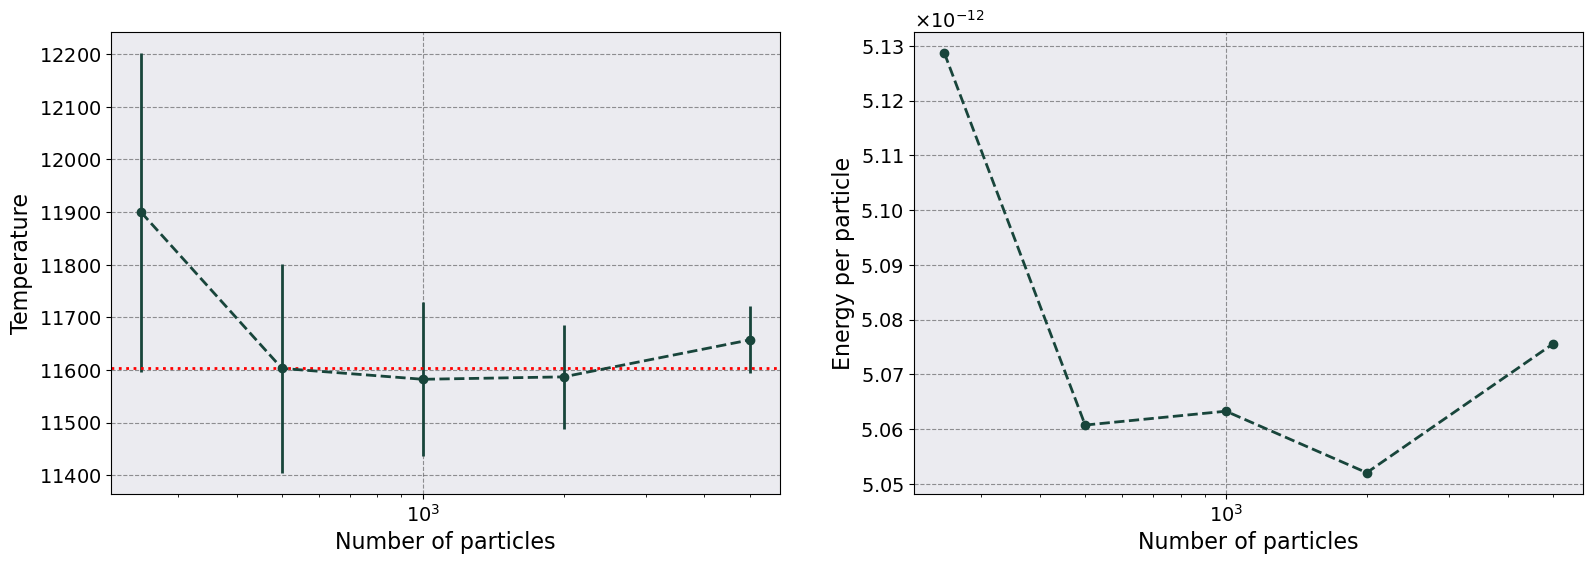

In [11]:
energy_data = []
energy_std = []
temp_data = []
temp_std = []

for i, N in enumerate(num_particles):

    args = {'Particles': [
        {"Species" :{
            'name' :'Al',
            'number_density': 6.03e+22,
            'mass': 4.513068464544e-23,
            'Z': 3.0,
            'temperature_eV': 1.0,
            'num': N,
            'replace': True
            }
        }
    ],
    "IO" : {
             'verbose': False,
            'job_dir': f'N{N}'
                }
    }
    # Initialize the Postprocessing class
    postproc = PostProcess(input_file_name)
    # Read the simulation's parameters and assign attributes
    postproc.setup(read_yaml=True, other_inputs=args)

    therm = Thermodynamics()
    therm.setup(postproc.parameters)
    therm.parse()
    # therm.temp_energy_plot(postproc)
    
    temp_data.append((therm.dataframe[("Temperature", "Mean")]).mean())
    temp_std.append((therm.dataframe[("Temperature", "Mean")]).std())

    energy_data.append((therm.dataframe[("Total Energy", "Mean")]/N).mean())
    energy_std.append((therm.dataframe[("Total Energy", "Mean")]/N).std())

    # rdf = RadialDistributionFunction()
    # rdf.setup(postproc.parameters)
    # rdf.compute()
    
    # rdf.plot(
    #     scaling=rdf.a_ws,
    #     y = [("Al-Al RDF", "Mean")],
    #     xlabel = r'$r/a_{\rm ws}$',
    #     ylabel = r'$g(r)$',
    #     ax = ax,
    # )

# ax.legend(['N = 100', 'N = 200', 'N = 500', 'N = 1000','N = 2000', 'N = 5000'])

fig, ax = plt.subplots(1,2, sharex = True, figsize = (19, 6))
ax[0].errorbar(num_particles, temp_data, yerr = temp_std, ls = '--', marker = 'o')
ax[1].errorbar(num_particles, energy_data, yerr = energy_std, ls = '--', marker = 'o')
ax[0].axhline(therm.T_desired, ls = ':', c = 'r')
ax[0].set( xlabel = 'Number of particles', ylabel = 'Temperature', xscale = 'log')
ax[1].set( xlabel = 'Number of particles', ylabel = 'Energy per particle', xscale = 'log')

**&#9989; Answer these questions:** What do you notice? Does the total energy per particle reach a plateau? Does the temperature? 

_Put your answers here_

Let's look at the Radial Distribution Function

In [12]:
def plot_rdf(input_file_name, args, ax):
    
    # Initialize the Postprocessing class
    postproc = PostProcess(input_file_name)
    # Read the simulation's parameters and assign attributes
    postproc.setup(read_yaml=True, other_inputs=args)

    rdf = RadialDistributionFunction()
    rdf.setup(postproc.parameters)
    rdf.compute()
    
    rdf.plot(
        scaling=rdf.a_ws,
        y = [("Al-Al RDF", "Mean")],
        xlabel = r'$r/a_{\rm ws}$',
        ylabel = r'$g(r)$',
        ax = ax,
    )

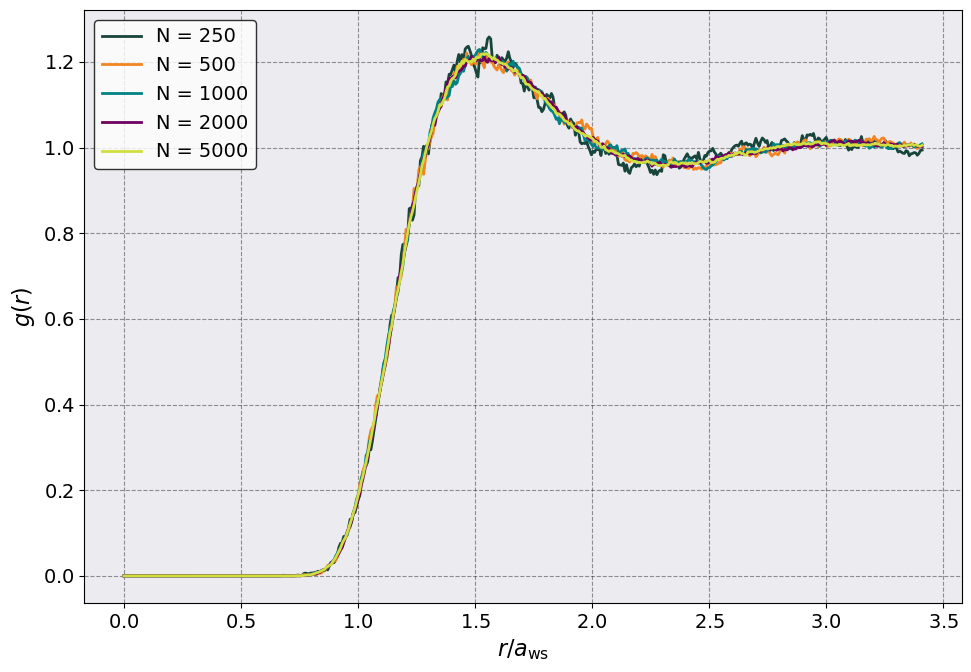

In [13]:
fig, ax = plt.subplots(1,1)

for i, N in enumerate(num_particles):

    args = {'Particles': [
        {"Species" :{
            'name' :'Al',
            'number_density': 6.03e+22,
            'mass': 4.513068464544e-23,
            'Z': 3.0,
            'temperature_eV': 1.0,
            'num': N,
            'replace': True
            }
        }
    ],
    "IO" : {
             'verbose': False,
            'job_dir': f'N{N}'
                }
    }
    plot_rdf(input_file_name, args, ax)

ax.legend([ f"N = {n}" for n in num_particles])


**&#9989; For the future:** Are you able to do the same analysis, but fixing the number of particles and changing the timestep, the cutoff radius?

Alright it seems that dt > 0.005 is too large. Let's try and change the cutoff radius. According the log file of the N2000 the box side is 20 a_ws. I am incrementing by small amount because I can see that the g(r) has already reached close to 1.

In [19]:
Np = 2000
rc_array = pre.parameters.a_ws * np.array([3.5, 4.0, 5.0, 6.0])
rc_array

array([5.52920877e-08, 6.31909574e-08, 7.89886967e-08, 9.47864361e-08])

In [16]:
# for i, rc in enumerate(rc_array):
    
#     args = {'Particles': [ 
#         {"Species" :{
#             'name' :'Al',
#             'number_density': 6.03e+22,
#             'mass': 4.513068464544e-23,
#             'Z': 3.0,
#             'temperature_eV': 1.0,
#             'num': Np,
#             'replace': True
#         }
#         }
#     ],
#     "Potential" : {"rc" : rc},
#     "IO" : {
#              'verbose': False,
#             'job_dir': f'rc_{rc/pre.parameters.a_ws:.1f}'
#                 }
#     }
#     # Initialize the Simulation class
#     sim = Simulation(input_file_name)
    
#     # Setup the simulation's parameters
#     sim.setup(read_yaml=True, other_inputs=args)
#     # Run the simulation
#     sim.run()
#     print(f"rc = {rc/pre.parameters.a_ws:.3f} done")

[Text(0.5, 0, '$r_c / a_{ws}$'), Text(0, 0.5, 'Energy per particle')]

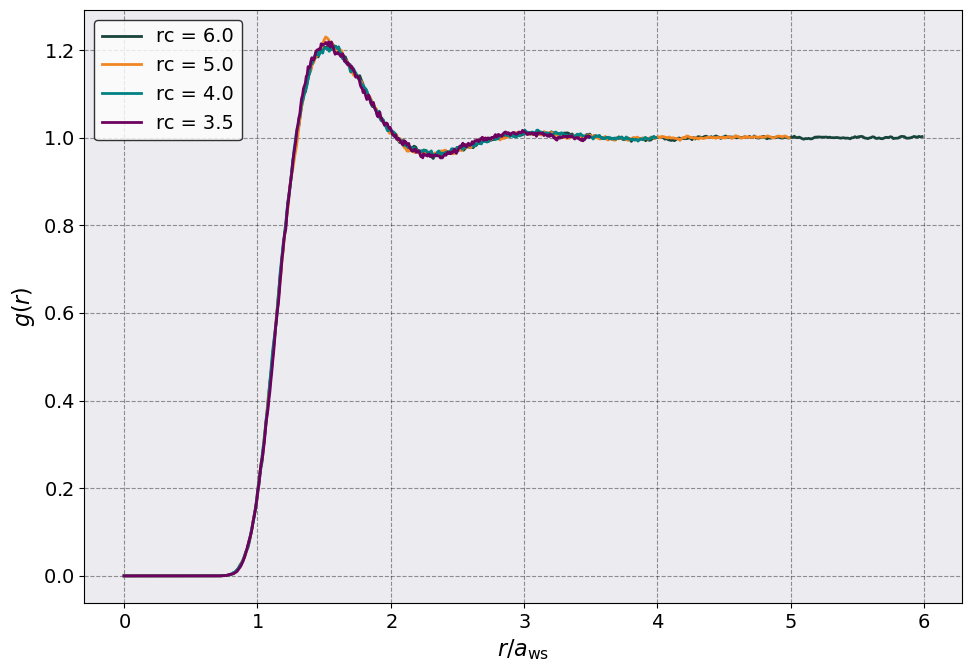

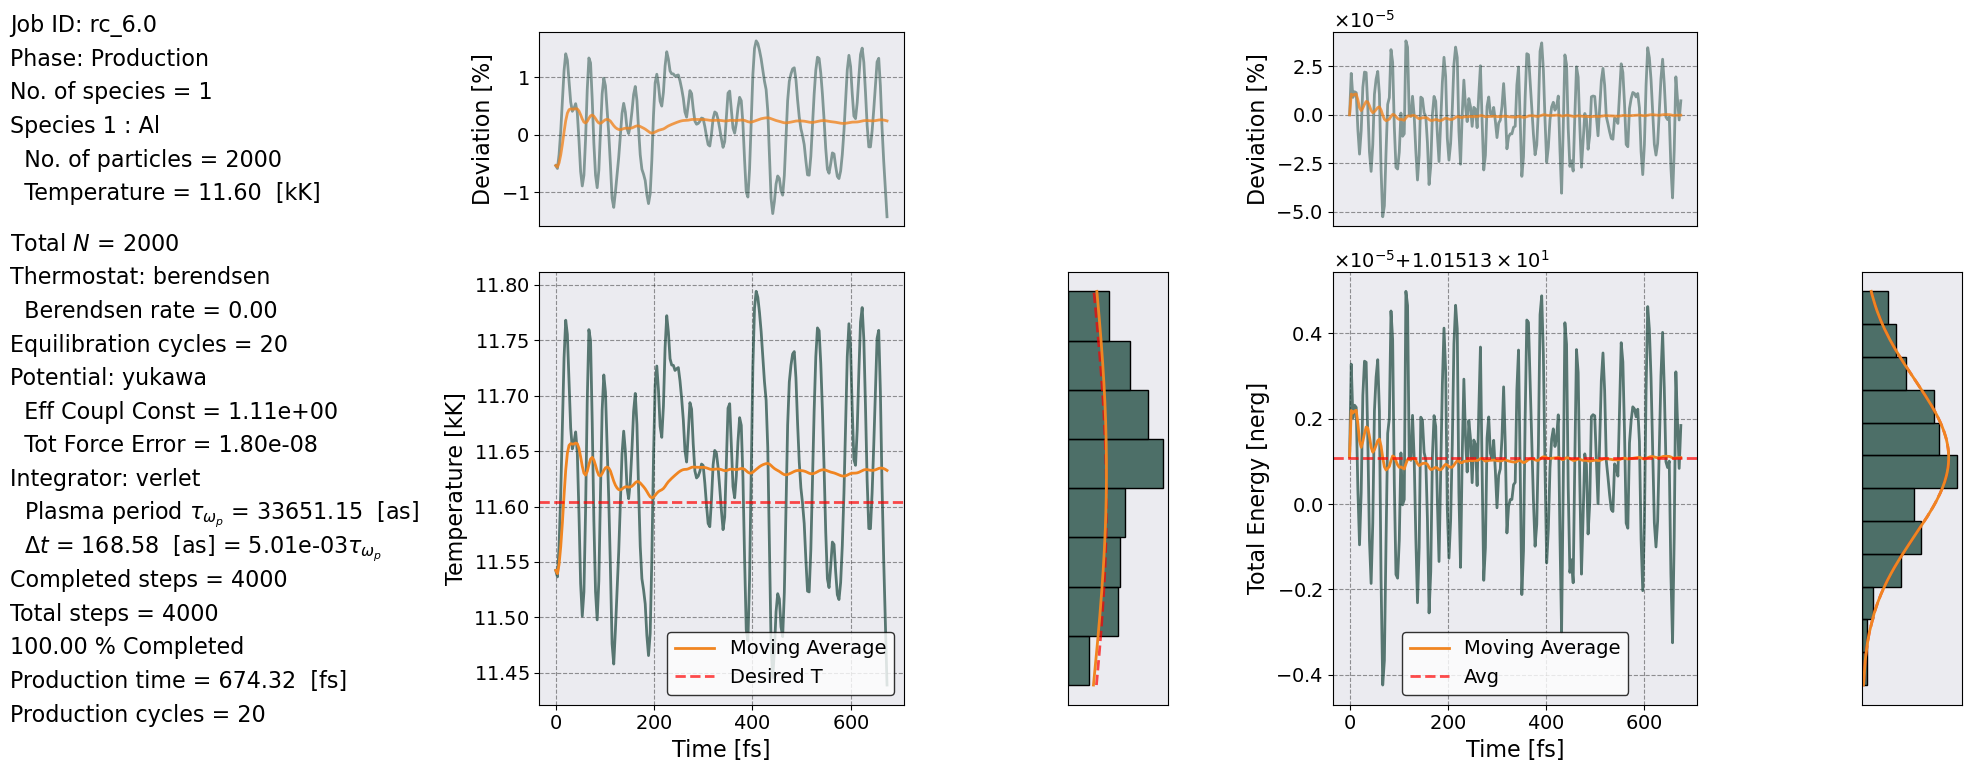

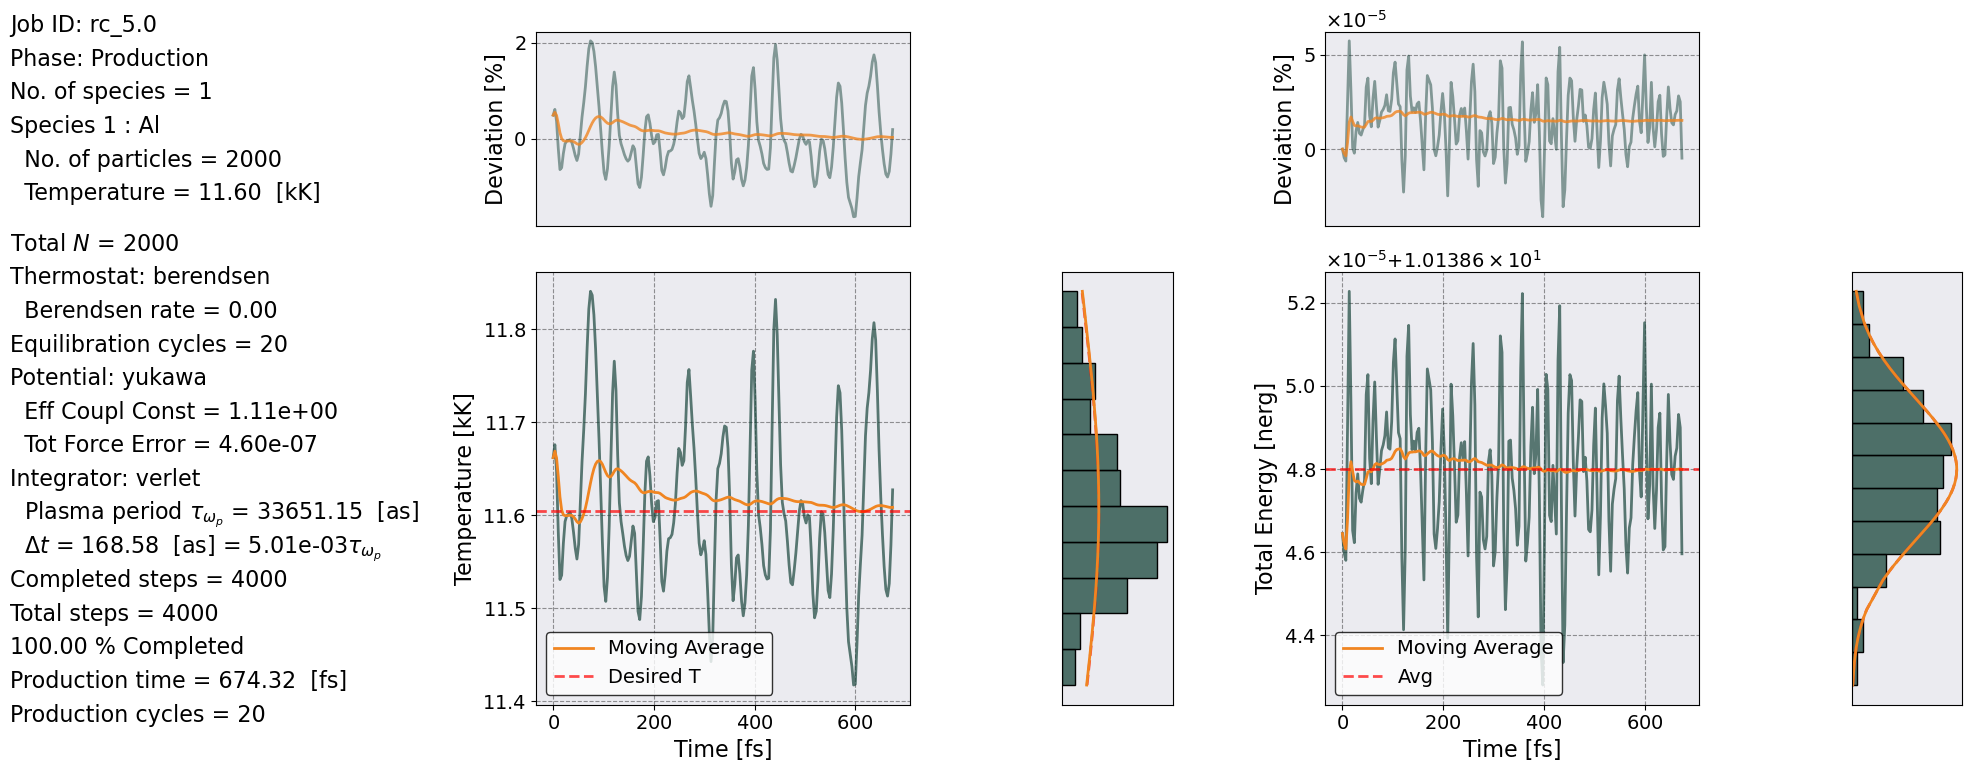

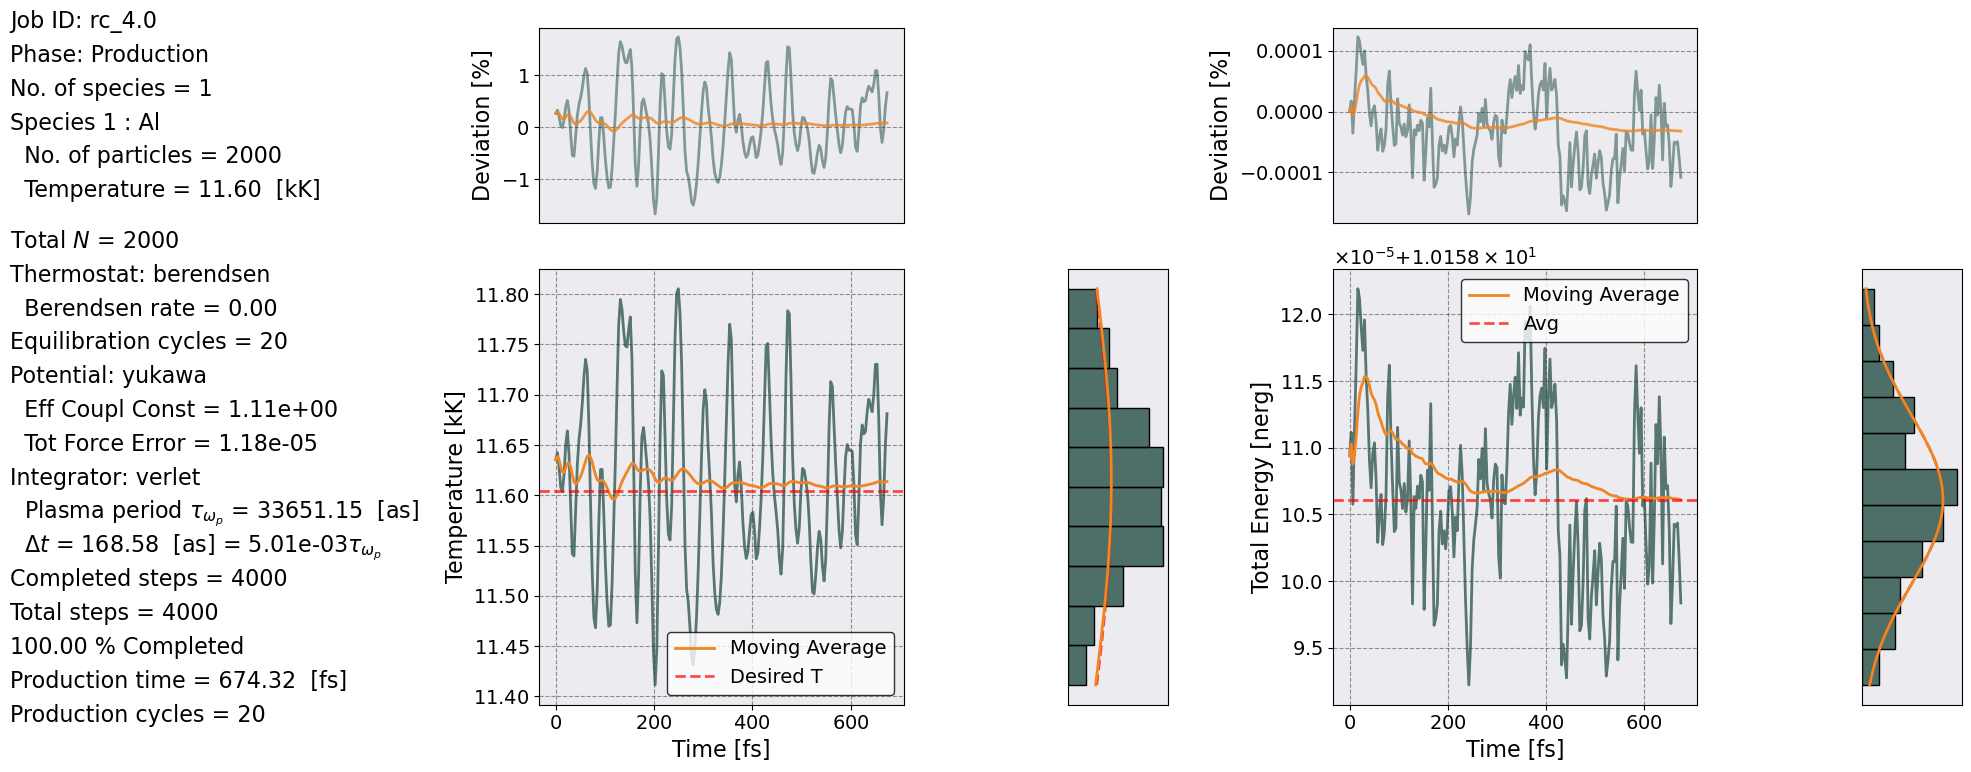

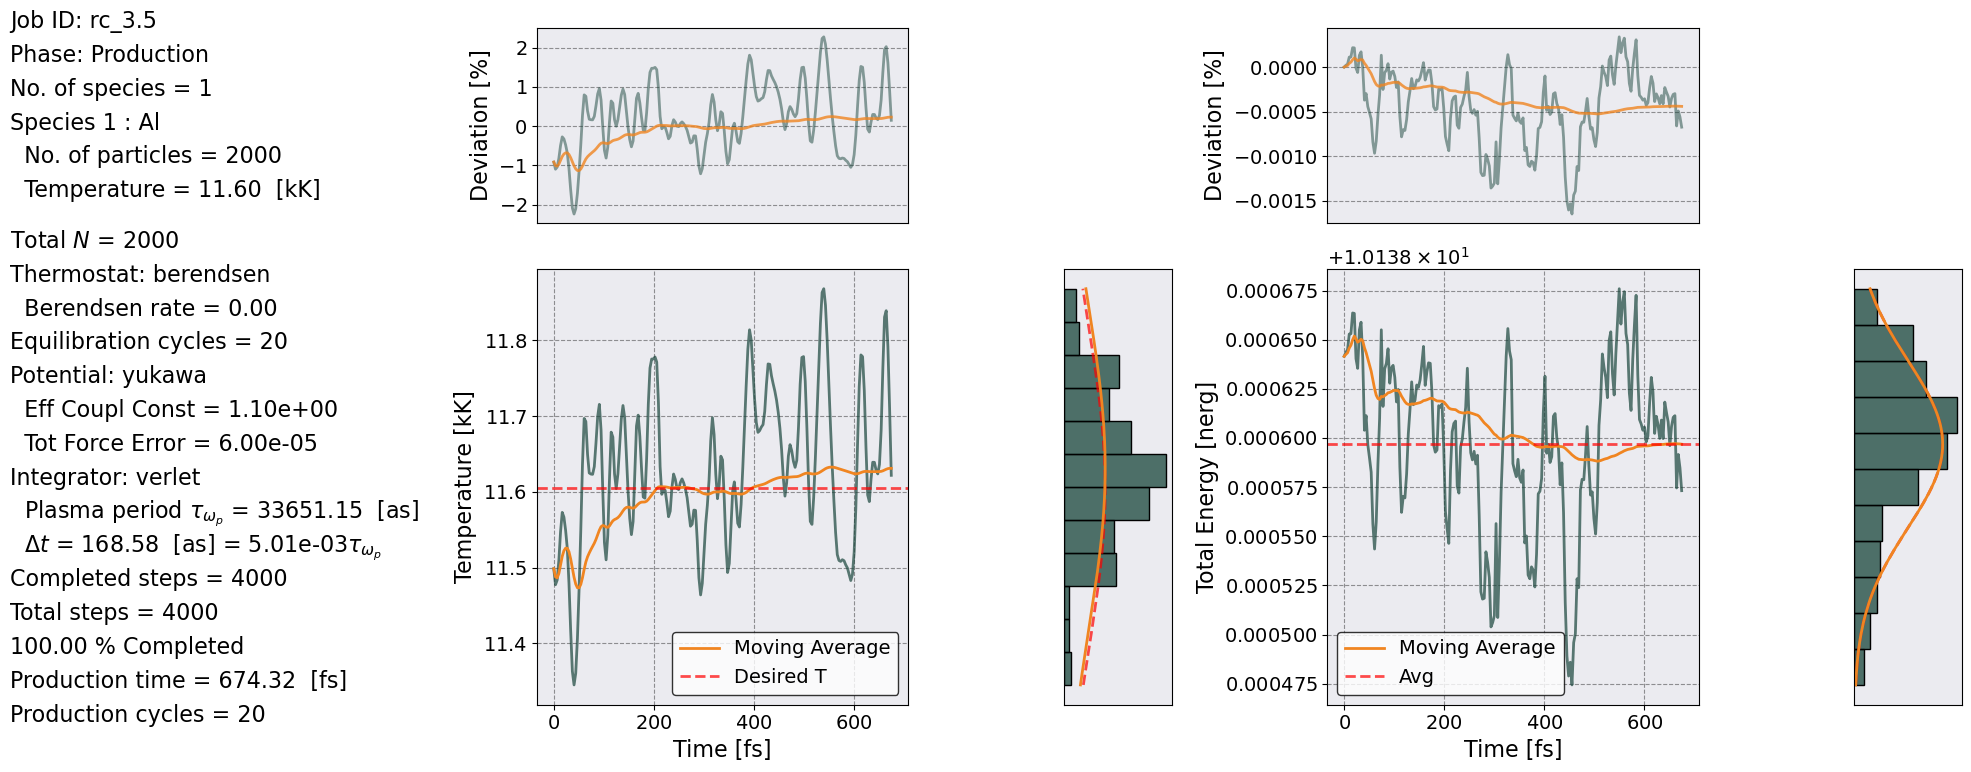

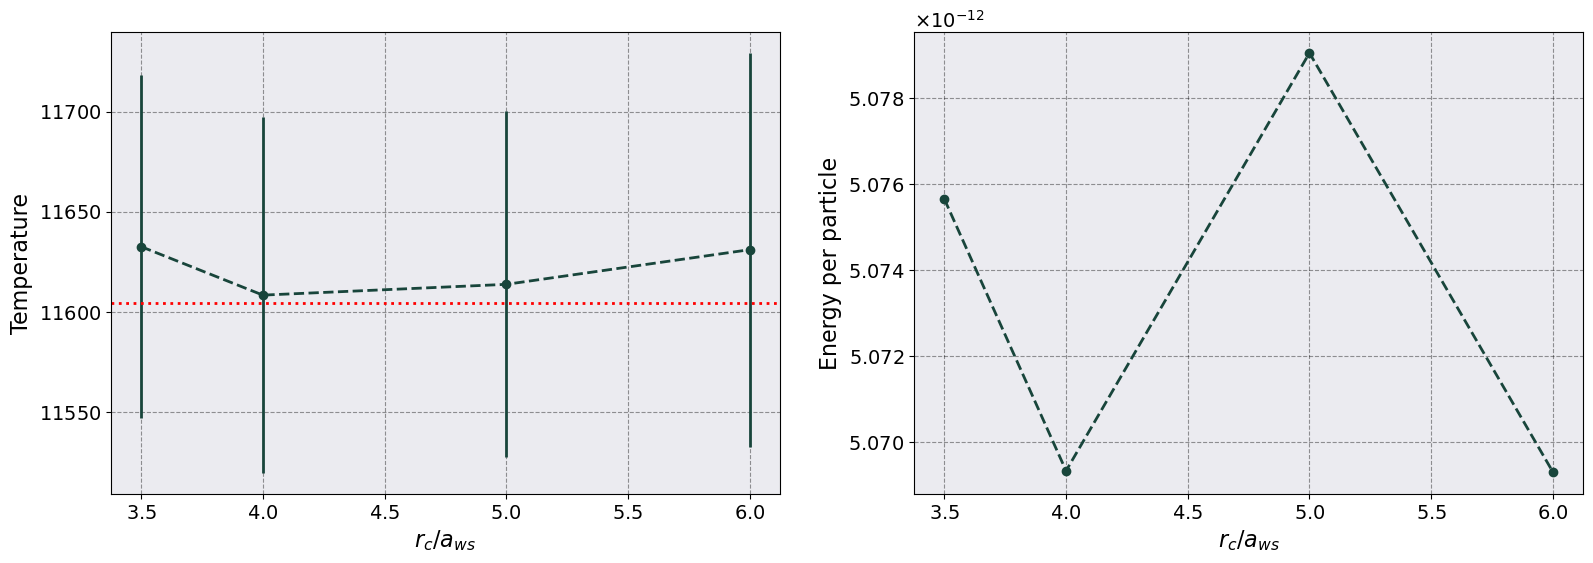

In [17]:
energy_data = []
energy_std = []
temp_data = []
temp_std = []

fig, ax = plt.subplots(1,1)

for i, rc in enumerate(rc_array[::-1]):
    
    args = {'Particles': [ 
        {"Species" :{
            'name' :'Al',
            'number_density': 6.03e+22,
            'mass': 4.513068464544e-23,
            'Z': 3.0,
            'temperature_eV': 1.0,
            'num': Np,
            'replace': True
        }
        }
    ],
    "Potential" : {"rc" : rc},
    "IO" : {
             'verbose': False,
            'job_dir': f'rc_{rc/pre.parameters.a_ws:.1f}'
                }
    }
    make_temp_energy_plot(input_file_name, args)
    plot_rdf(input_file_name, args, ax)

    # Initialize the Postprocessing class
    postproc = PostProcess(input_file_name)
    # Read the simulation's parameters and assign attributes
    postproc.setup(read_yaml=True, other_inputs=args)

    therm = Thermodynamics()
    therm.setup(postproc.parameters)
    therm.parse()
    # therm.temp_energy_plot(postproc)
    
    temp_data.append((therm.dataframe[("Temperature", "Mean")]).mean())
    temp_std.append((therm.dataframe[("Temperature", "Mean")]).std())

    energy_data.append((therm.dataframe[("Total Energy", "Mean")]/Np).mean())
    energy_std.append((therm.dataframe[("Total Energy", "Mean")]/Np).std())

ax.legend([ f"rc = {rc/pre.parameters.a_ws}" for rc in rc_array[::-1] ])

fig, ax = plt.subplots(1,2, sharex = True, figsize = (19, 6))
ax[0].errorbar(rc_array/pre.parameters.a_ws, temp_data, yerr = temp_std, ls = '--', marker = 'o')
ax[1].errorbar(rc_array/pre.parameters.a_ws, energy_data, yerr = energy_std, ls = '--', marker = 'o')
ax[0].axhline(therm.T_desired, ls = ':', c = 'r')
ax[0].set( xlabel = r'$r_c / a_{ws}$', ylabel = 'Temperature')
ax[1].set( xlabel = r'$r_c / a_{ws}$', ylabel = 'Energy per particle')


In [30]:
cut_off = 6.0 * pre.parameters.a_ws
dt_array = np.array([0.005, 0.01, 0.02, 0.05, 0.1]) * tau_wp 

In [31]:
# for i, dt in enumerate(dt_array):

#     # Need to change the thermostat.
#     # tau necessary to decay to 0.01 within 5 plasma periods
#     tau_B = - 10.0 * tau_wp/np.log(0.01)/dt

#     N_steps = int(30*tau_wp/dt)
#     dump_step = int(0.2 * tau_wp/dt)
#     N_eq = 2.0 * tau_wp/dt
    
#     args = {'Particles': [ 
#         {"Species" :{
#             'name' :'Al',
#             'number_density': 6.03e+22,
#             'mass': 4.513068464544e-23,
#             'Z': 3.0,
#             'temperature_eV': 1.0,
#             'num': Np,
#             'replace': True
#         }
#         }
#     ],
#     "Potential": {"rc" : cut_off},
#     "Integrator" : {
#         "dt" : dt,
#         "thermalization_timestep": N_eq,
#         "berendsen_tau" : tau_B},
#     "Parameters" : {
#         "equilibration_steps": N_steps,
#         "production_steps": N_steps,
#         "eq_dump_step": dump_step,
#         "prod_dump_step": dump_step,
#     },
    
#     "IO" : {
#              'verbose': True,
#             'job_dir': f'dt_{dt/tau_wp:.3f}'
#                 }
#     }
#     # Initialize the Simulation class
#     sim = Simulation(input_file_name)
    
#     # Setup the simulation's parameters
#     sim.setup(read_yaml=True, other_inputs=args)
#     # Run the simulation
#     sim.run()
#     print(f"dt = {dt/tau_wp:.3f} done")

[Text(0.5, 0, '$\\Delta t / \\tau_{\\omega_p}$'),
 Text(0, 0.5, 'Energy per particle')]

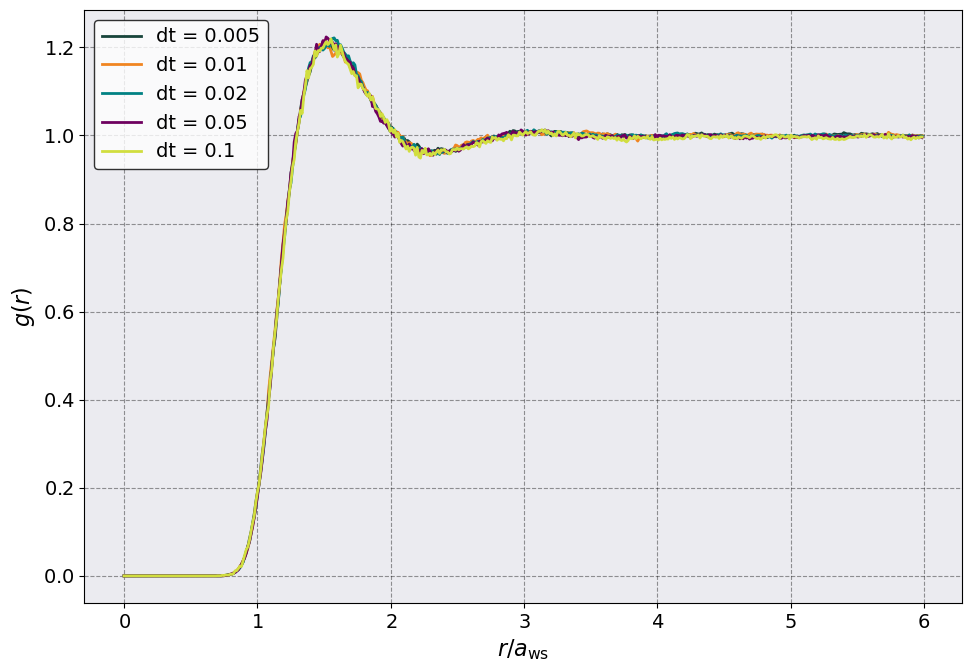

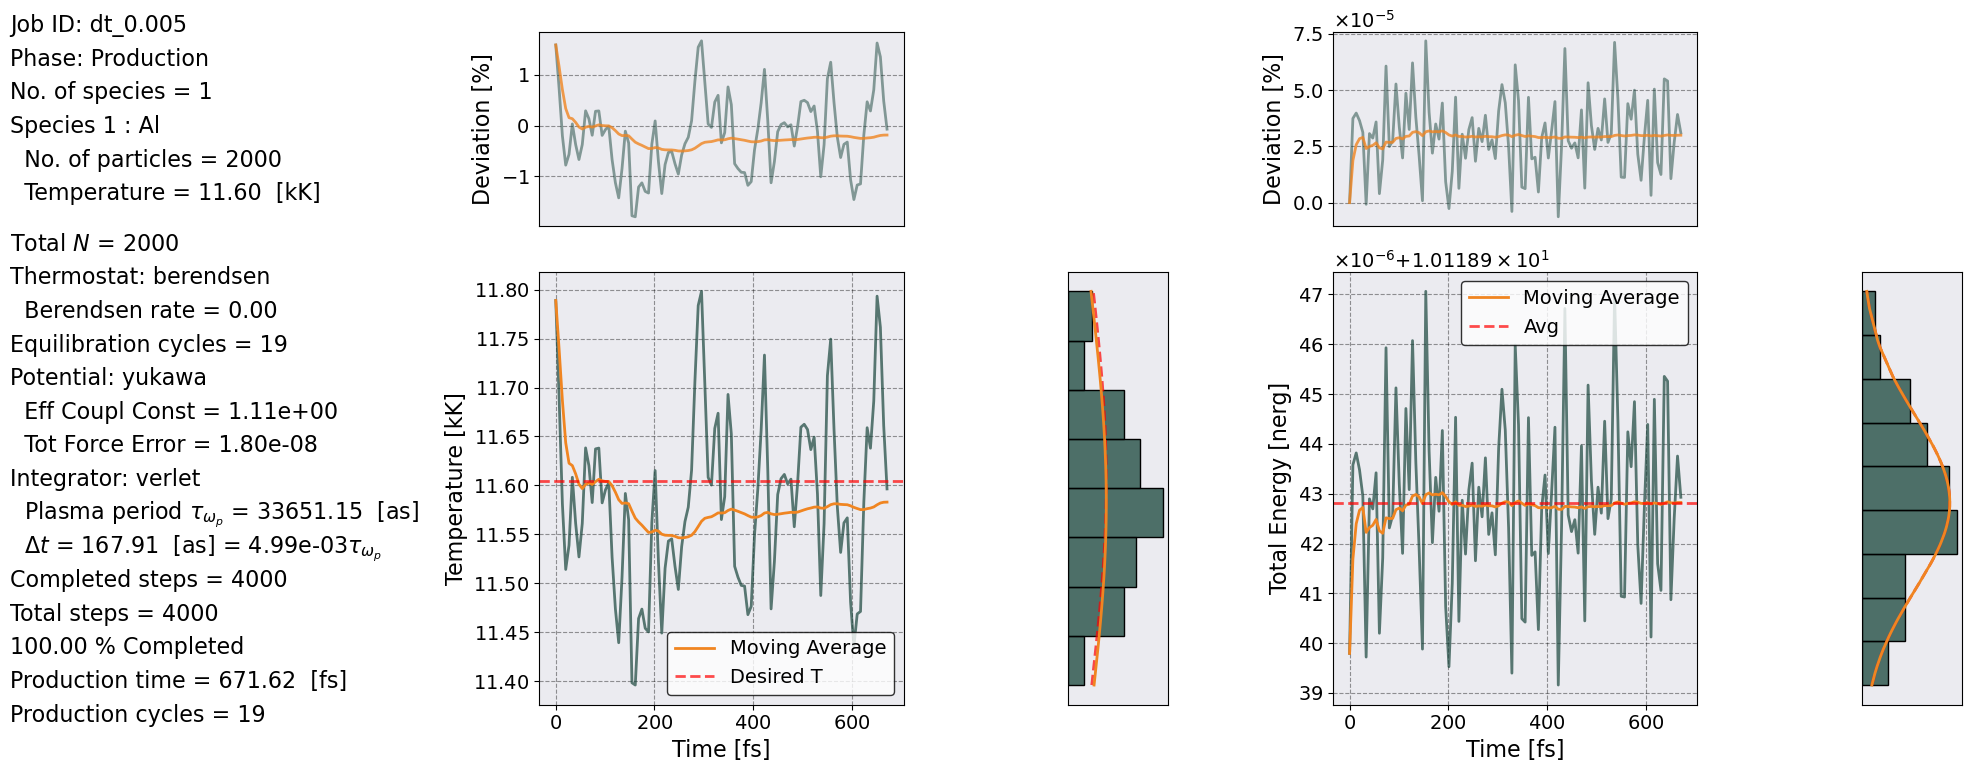

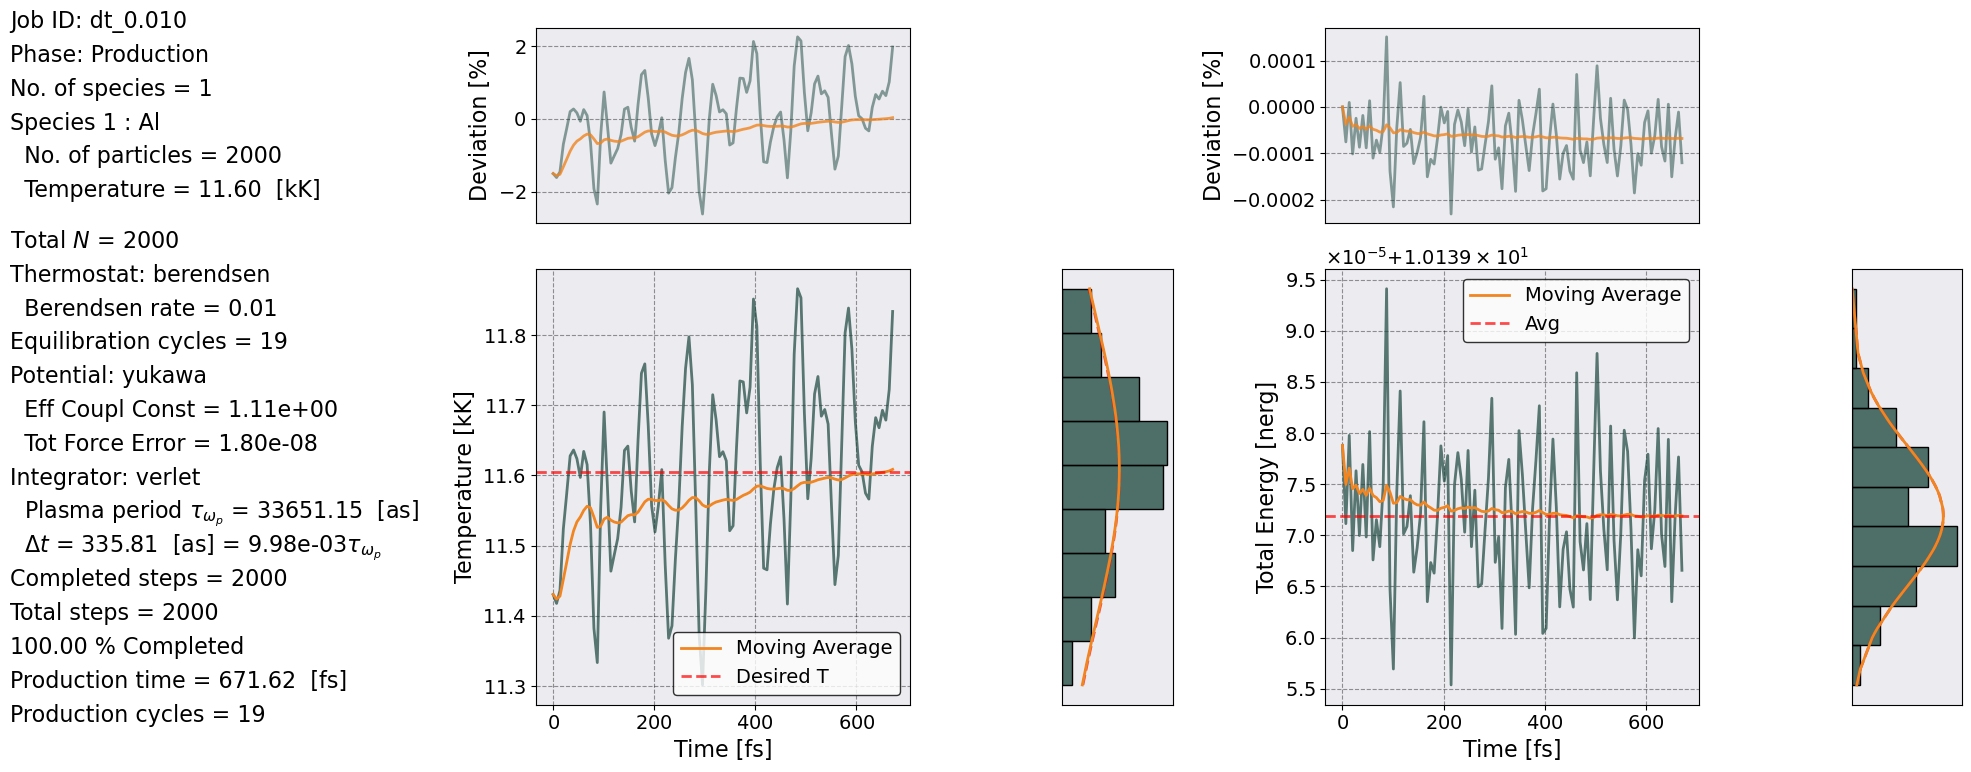

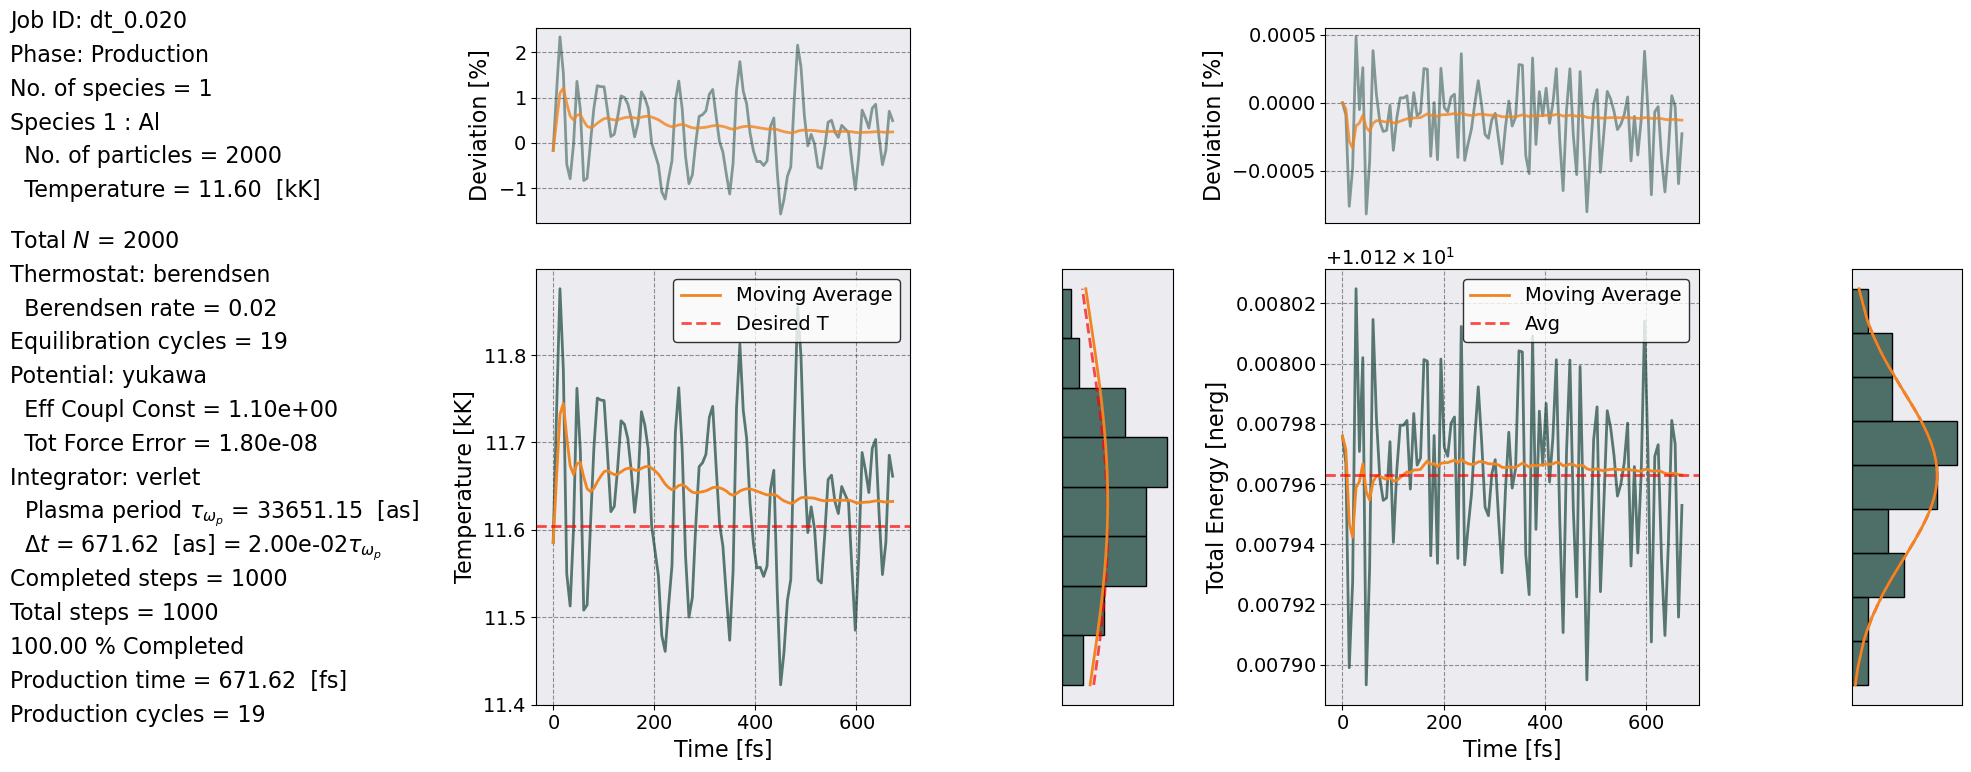

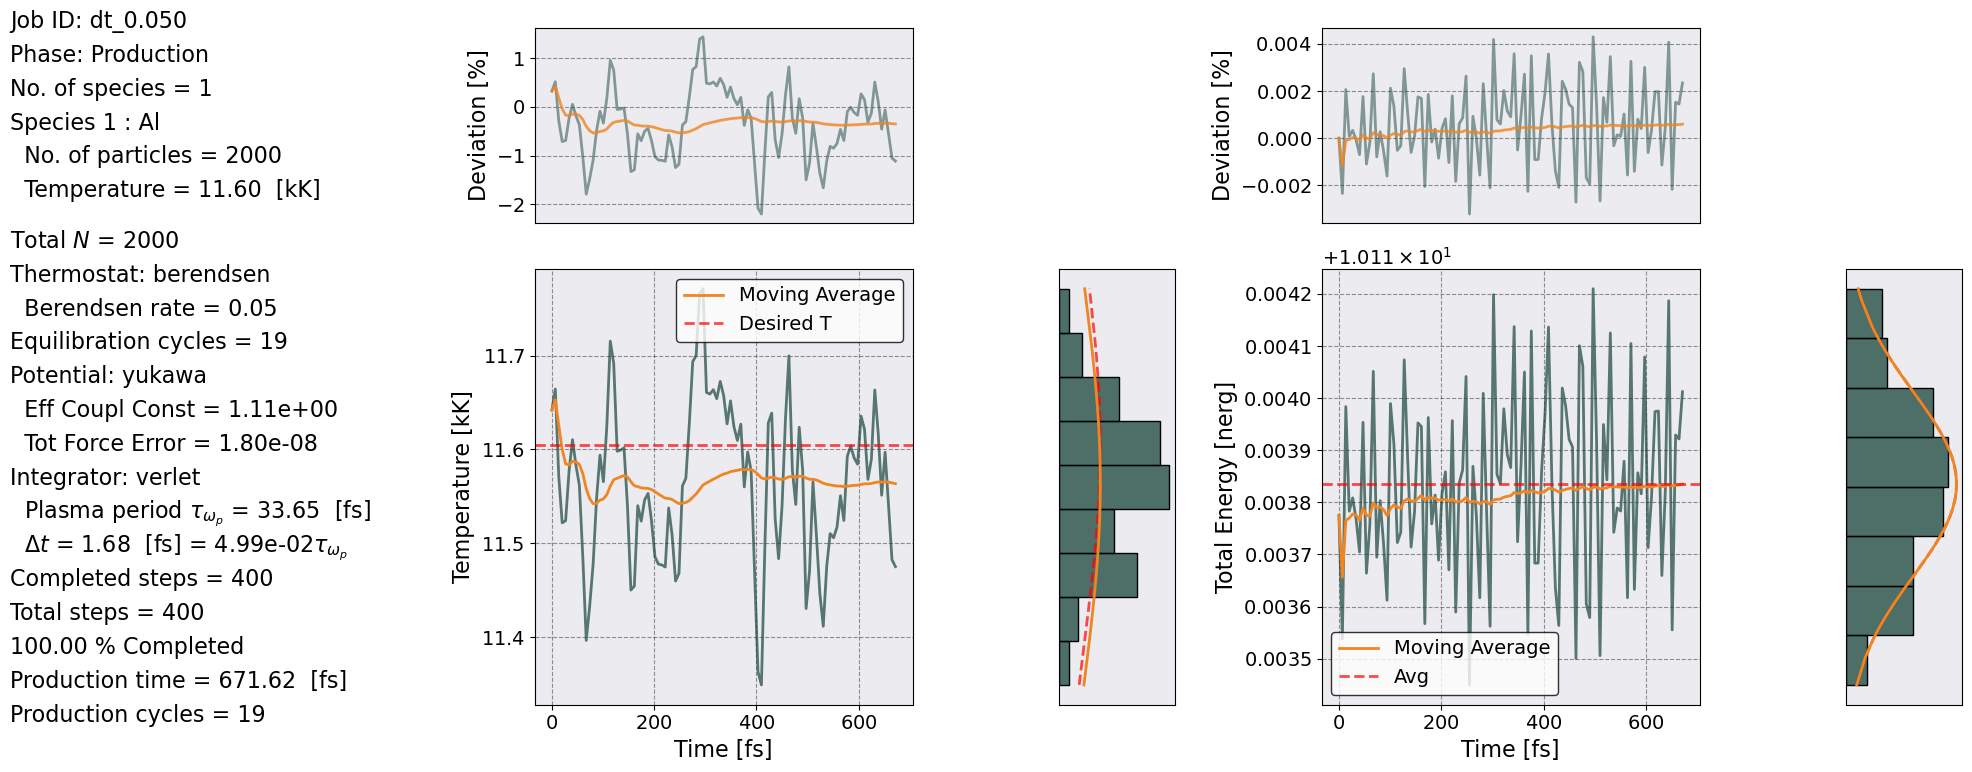

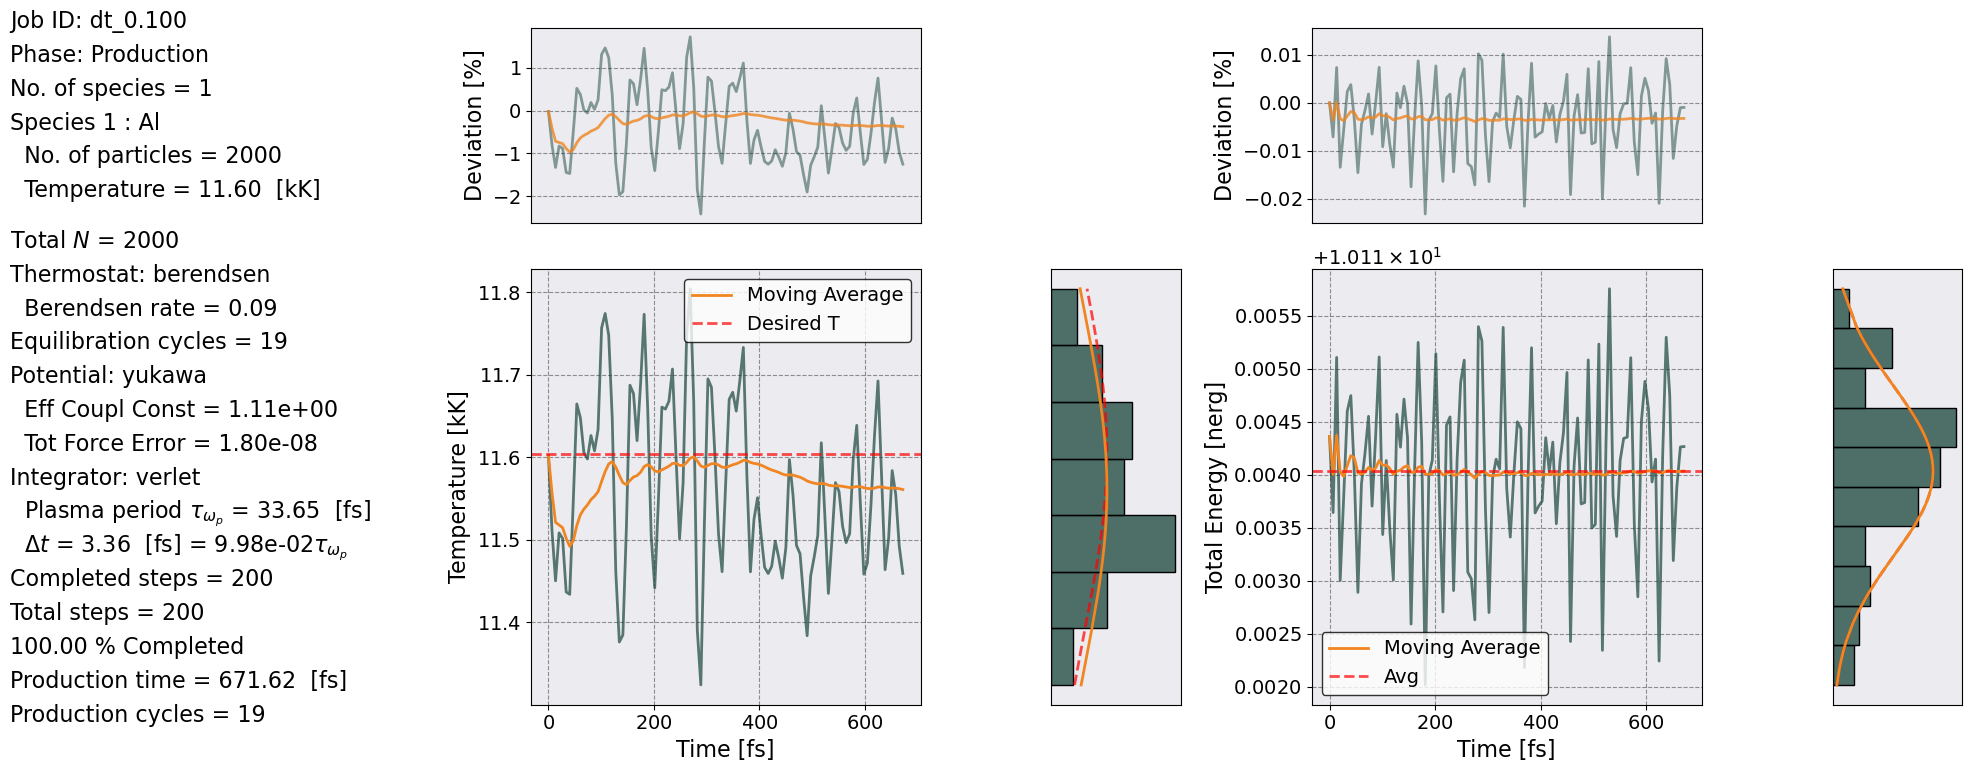

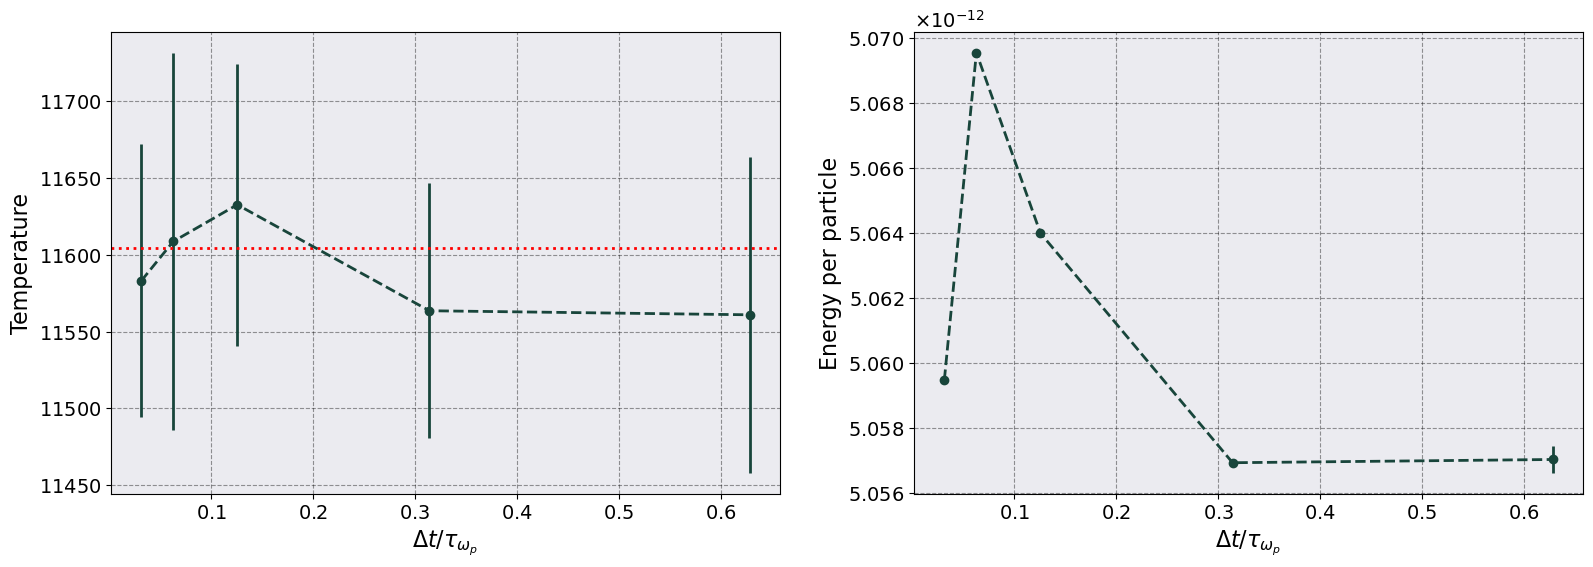

In [36]:
energy_data = []
energy_std = []
temp_data = []
temp_std = []

fig, ax = plt.subplots(1,1)

for i, dt in enumerate(dt_array):
    
    # Need to change the thermostat.
    # tau necessary to decay to 0.01 within 5 plasma periods
    tau_B = - 5.0 * tau_wp/np.log(0.01)/dt
    N_eq = int(2.0 * tau_wp/dt)
    
    N_steps = int(20*tau_wp/dt)
    dump_step = int(0.2 * tau_wp/dt)
    
    args = {'Particles': [ 
        {"Species" :{
            'name' :'Al',
            'number_density': 6.03e+22,
            'mass': 4.513068464544e-23,
            'Z': 3.0,
            'temperature_eV': 1.0,
            'num': Np,
            'replace': True
        }
        }
    ],
    "Potential": {"rc" : cut_off},
    "Integrator" : {
        "dt" : dt,
        "thermalization_timestep" : N_eq,
        "berendsen_tau" : tau_B},
    "Parameters" : {
        "equilibration_steps": N_steps,
        "production_steps": N_steps,
        "eq_dump_step": dump_step,
        "prod_dump_step": dump_step,
    },
    
    "IO" : {
             'verbose': False,
            'job_dir': f'dt_{dt/tau_wp:.3f}'
                }
    }
    make_temp_energy_plot(input_file_name, args)
    plot_rdf(input_file_name, args, ax)

    # Initialize the Postprocessing class
    postproc = PostProcess(input_file_name)
    # Read the simulation's parameters and assign attributes
    postproc.setup(read_yaml=True, other_inputs=args)

    therm = Thermodynamics()
    therm.setup(postproc.parameters)
    therm.compute()
    # therm.temp_energy_plot(postproc)
    
    temp_data.append((therm.dataframe[("Temperature", "Mean")]).mean())
    temp_std.append((therm.dataframe[("Temperature", "Mean")]).std())

    energy_data.append((therm.dataframe[("Total Energy", "Mean")]/Np).mean())
    energy_std.append((therm.dataframe[("Total Energy", "Mean")]/Np).std())

ax.legend([ f"dt = {dt/tau_wp}" for dt in dt_array ])

fig, ax = plt.subplots(1,2, sharex = True, figsize = (19, 6))
ax[0].errorbar(dt_array/tau_wp, temp_data, yerr = temp_std, ls = '--', marker = 'o')
ax[1].errorbar(dt_array/tau_wp, energy_data, yerr = energy_std, ls = '--', marker = 'o')
ax[0].axhline(therm.T_desired, ls = ':', c = 'r')
ax[0].set( xlabel = r'$\Delta t / \tau_{\omega_p}$', ylabel = 'Temperature')
ax[1].set( xlabel = r'$\Delta t / \tau_{\omega_p}$', ylabel = 'Energy per particle')


In [19]:
therm.simulation_dataframe

Time  Total Energy  Kinetic Energy  Potential Energy  \
0    0.000000e+00  3.945963e-08    4.941696e-09      3.451794e-08   
1    4.963835e-15  4.017240e-08    2.646716e-08      1.370524e-08   
2    9.927670e-15  4.017927e-08    2.991028e-08      1.026899e-08   
3    1.489151e-14  4.018244e-08    3.079319e-08      9.389250e-09   
4    1.985534e-14  4.017757e-08    3.096368e-08      9.213888e-09   
..            ...           ...             ...               ...   
96   4.765282e-13  1.009182e-08    4.812013e-09      5.279809e-09   
97   4.814920e-13  1.008923e-08    4.829407e-09      5.259823e-09   
98   4.864558e-13  1.008481e-08    4.827917e-09      5.256896e-09   
99   4.914197e-13  1.008198e-08    4.812953e-09      5.269029e-09   
100  4.963835e-13  1.008288e-08    4.786206e-09      5.296670e-09   

      Temperature  
0    11930.853325  
1    63900.298435  
2    72213.100333  
3    74344.717762  
4    74756.338317  
..            ...  
96   11617.756000  
97   11659.751402  
98   11656.153596  
99   11620.024456  
100  11555.450345  

[101 rows x 5 columns]